# Okoliščine prometnih nesreč

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pn2022 = pd.read_csv('data/pn2022.csv', 
                    encoding="ISO-8859-1",
                    delimiter=";")

char_map = {"\x8a": "Š", "\x8e": "Ž", "È": "Č"}

for col in pn2022.columns:
    if pn2022[col].dtype == 'object':
        pn2022[col] = pn2022[col].str.translate(str.maketrans(char_map))

Ustvarimo `pn2022` DataFrame s podatki o prometnih nesrečah za leto 2022 in poskrbimo za pravilen prikaz šumnikov.

## Prometne nesreče po dnevih in delih dneva

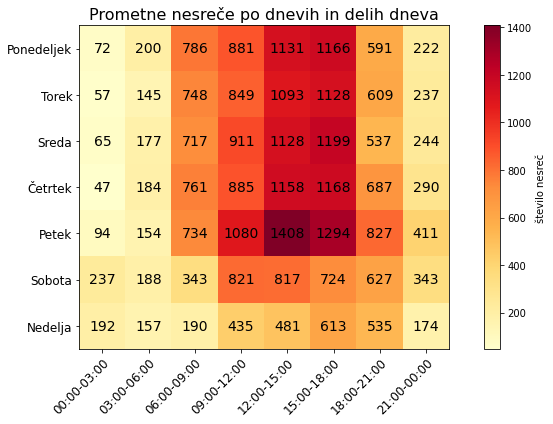

In [9]:
dow = {"Monday": "Ponedeljek", "Tuesday": "Torek", "Wednesday": "Sreda", "Thursday": "Četrtek", "Friday": "Petek", "Saturday": "Sobota", "Sunday": "Nedelja"}

pn2022['DatumPN'] = pd.to_datetime(pn2022['DatumPN'], format='%d.%m.%Y')
pn2022['DayOfWeek'] = pn2022['DatumPN'].dt.day_name()
pn2022['DayOfWeek'] = pn2022['DayOfWeek'].replace(dow)

time_intervals = ['00:00-03:00', '03:00-06:00', '06:00-09:00', '09:00-12:00', '12:00-15:00', '15:00-18:00', '18:00-21:00', '21:00-00:00']

pn2022['TimeInterval'] = pd.cut(np.ceil(pn2022['UraPN']), bins=[0, 3, 6, 9, 12, 15, 18, 21, 24], labels=time_intervals)

accidents_by_day_time = pn2022.groupby(['DayOfWeek', 'TimeInterval']).size().reset_index(name='count')

pivoted_data = accidents_by_day_time.pivot(index='DayOfWeek', columns='TimeInterval', values='count')
pivoted_data = pivoted_data.loc[['Ponedeljek', 'Torek', 'Sreda', 'Četrtek', 'Petek', 'Sobota', 'Nedelja']]

data = pivoted_data.values

x_labels = pivoted_data.columns.values
y_labels = pivoted_data.index.values

fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(data, cmap='YlOrRd')

ax.set_xticks(np.arange(len(x_labels)))
ax.set_yticks(np.arange(len(y_labels)))
ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)

plt.setp(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), fontsize=12)

for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        text = ax.text(j, i, data[i, j], ha="center", va="center", color="black", fontsize=14)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("število nesreč")

ax.set_title("Prometne nesreče po dnevih in delih dneva", fontsize=16)
plt.tight_layout()
#plt.savefig("dnevi.jpg")
plt.show()

## Prometne nesreče in izidi glede na vremenske okoliščine

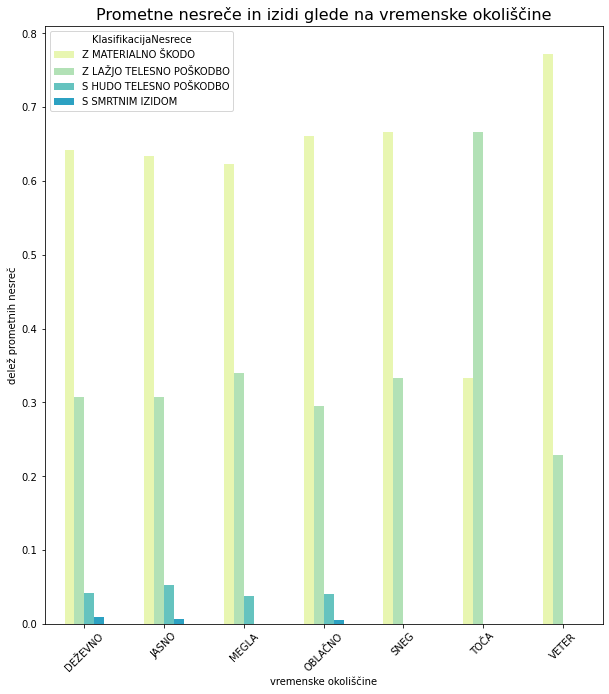

In [3]:
total_crashes = pn2022.groupby('VremenskeOkoliscine').size()

filtered = pn2022[pn2022['VremenskeOkoliscine'] != 'NEZNANO']
grouped_data = filtered.groupby(['VremenskeOkoliscine', 'KlasifikacijaNesrece']).size().reset_index(name='counts')
grouped_data['odstotek'] = grouped_data.apply(lambda row: row['counts'] / total_crashes[row['VremenskeOkoliscine']], axis=1)

order = ['Z MATERIALNO ŠKODO', 'Z LAŽJO TELESNO POŠKODBO', 'S HUDO TELESNO POŠKODBO', 'S SMRTNIM IZIDOM']
pivoted_data = grouped_data.pivot(index='VremenskeOkoliscine', columns='KlasifikacijaNesrece', values='odstotek')
pivoted_data = pivoted_data.reindex(columns=order)

pivoted_data.plot(kind='bar', color=sns.color_palette("YlGnBu"), figsize=(10, 11), position=0.5)

plt.xlabel('vremenske okoliščine')
plt.ylabel('delež prometnih nesreč')
plt.xticks(rotation=45)
plt.title('Prometne nesreče in izidi glede na vremenske okoliščine', fontsize=16)
#plt.savefig("vreme.jpg")
plt.show()

## Prometne nesreče in izidi glede na vrsto nesreče

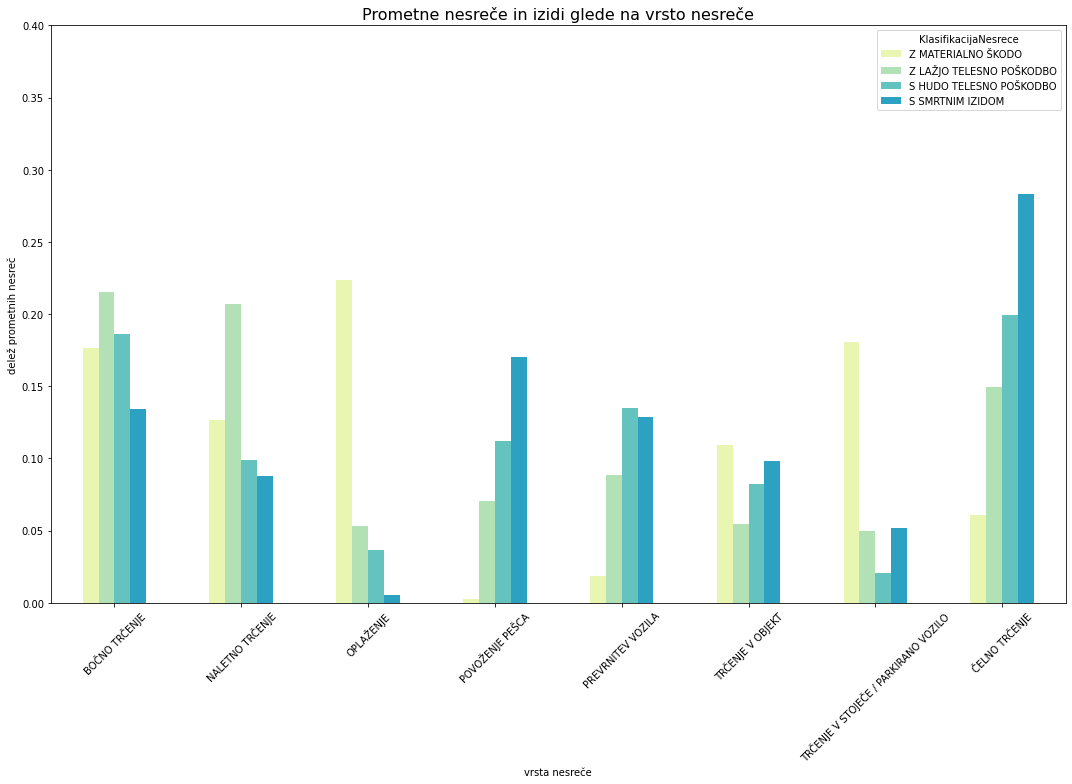

In [10]:
total_crashes = pn2022.groupby('KlasifikacijaNesrece').size()

filtered1 = pn2022[ pn2022["TipNesrece"] != "POVOŽENJE ŽIVALI" ]
filtered = filtered1[ filtered1["TipNesrece"] != "OSTALO" ]
grouped_data = filtered.groupby(['TipNesrece', 'KlasifikacijaNesrece']).size().reset_index(name='counts')
grouped_data['odstotek'] = grouped_data.apply(lambda row: row['counts'] / total_crashes[row['KlasifikacijaNesrece']], axis=1)

order = ['Z MATERIALNO ŠKODO', 'Z LAŽJO TELESNO POŠKODBO', 'S HUDO TELESNO POŠKODBO', 'S SMRTNIM IZIDOM']
pivoted_data = grouped_data.pivot(index='TipNesrece', columns='KlasifikacijaNesrece', values='odstotek')
pivoted_data = pivoted_data.reindex(columns=order)

pivoted_data.plot(kind='bar', color=sns.color_palette("YlGnBu"), figsize=(15, 11), position=0.5)

plt.xlabel('vrsta nesreče')
plt.ylabel('delež prometnih nesreč')
plt.xticks(rotation=45)
plt.ylim(0,0.4)
plt.title('Prometne nesreče in izidi glede na vrsto nesreče', fontsize=16)
plt.tight_layout()
#plt.savefig("vrsta.jpg")
plt.show()

## Vzroki prometnih nesreč

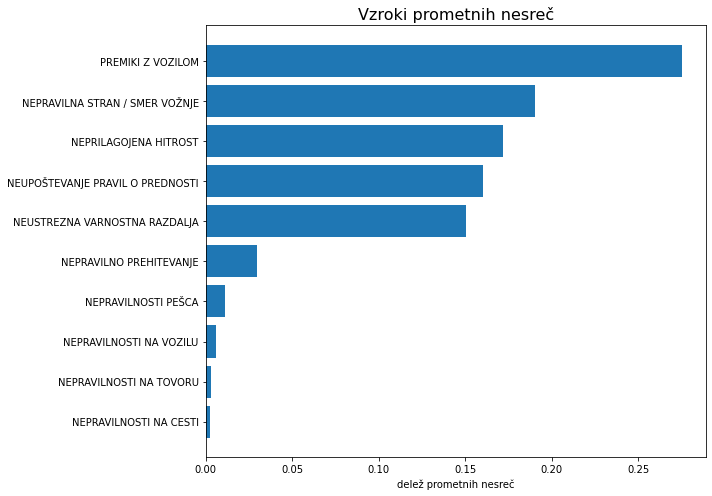

In [11]:
filtered = pn2022[ pn2022["VzrokNesrece"] != "OSTALO" ]
counts = filtered['VzrokNesrece'].value_counts().sort_values(ascending=False)

fig = plt.figure(figsize =(10, 7))
plt.barh(filtered['VzrokNesrece'].unique(), counts / sum(counts)) # barh zaradi lažje berljivosti
plt.gca().invert_yaxis()
plt.title("Vzroki prometnih nesreč", fontsize=16)
plt.xlabel('delež prometnih nesreč')
plt.tight_layout()
#plt.savefig("vzroki.jpg")
plt.show()

## Gostota prometa ob nesrečah

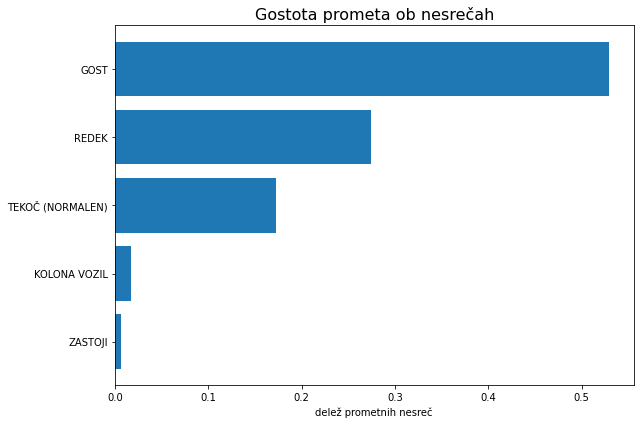

In [12]:
filtered = pn2022[ pn2022["StanjePrometa"] != "NEZNANO" ]
counts = filtered['StanjePrometa'].value_counts().sort_values(ascending=False)

fig = plt.figure(figsize =(9, 6))
plt.barh(filtered['StanjePrometa'].unique(), counts / sum(counts))  # barh zaradi lažje berljivosti
plt.gca().invert_yaxis()
plt.title("Gostota prometa ob nesrečah", fontsize=16)
plt.xlabel('delež prometnih nesreč')
plt.tight_layout()
#plt.savefig("promet.jpg")
plt.show()